In [1]:
library(tidyverse)
library(here)
library(glue)
library(furrr)
library(cowplot)
library(lemon)

devtools::load_all(".")

plan(multiprocess)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
here() starts at /mnt/expressions/mp/ychr

Attaching package: ‘glue’

The following object is masked from ‘package:dplyr’:

    collapse

Loading required package: future

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************


Attaching package: ‘lemon’

The following object is masked from ‘package:purrr’:

    %||%

Loading ychr


In [2]:
sel_sims <-
    map_dfr(sprintf("%d", seq(100000, 2000000, 100000)), function(gene_total) {
    map_dfr(sprintf("%.2f", seq(0.01, 0.1, 0.01)), function(admix_rate) {
    map_dfr(sprintf("%d", (seq(200000, 450000, 50000))), function(admix_time) {
    future_map_dfr(1:25, function(rep) {

f <- here(glue("data/newsim/modern2neand_sel_chrY_seq{gene_total}_rate{admix_rate}_time{admix_time}_rep{rep}.txt"))
if (!file.exists(f)) return(NULL)

read_tsv(f, col_types = "idd") %>%
    mutate(admix_rate = admix_rate, gene_total = gene_total, admix_time = admix_time, rep = rep)

    })
    })
    })
    }) %>%
    mutate_all(as.numeric) %>%
    mutate(time = gen * 25) %>%
    select(-gen)

In [3]:
saveRDS(sel_sims, here("data/rds/sel_sims.rds"))

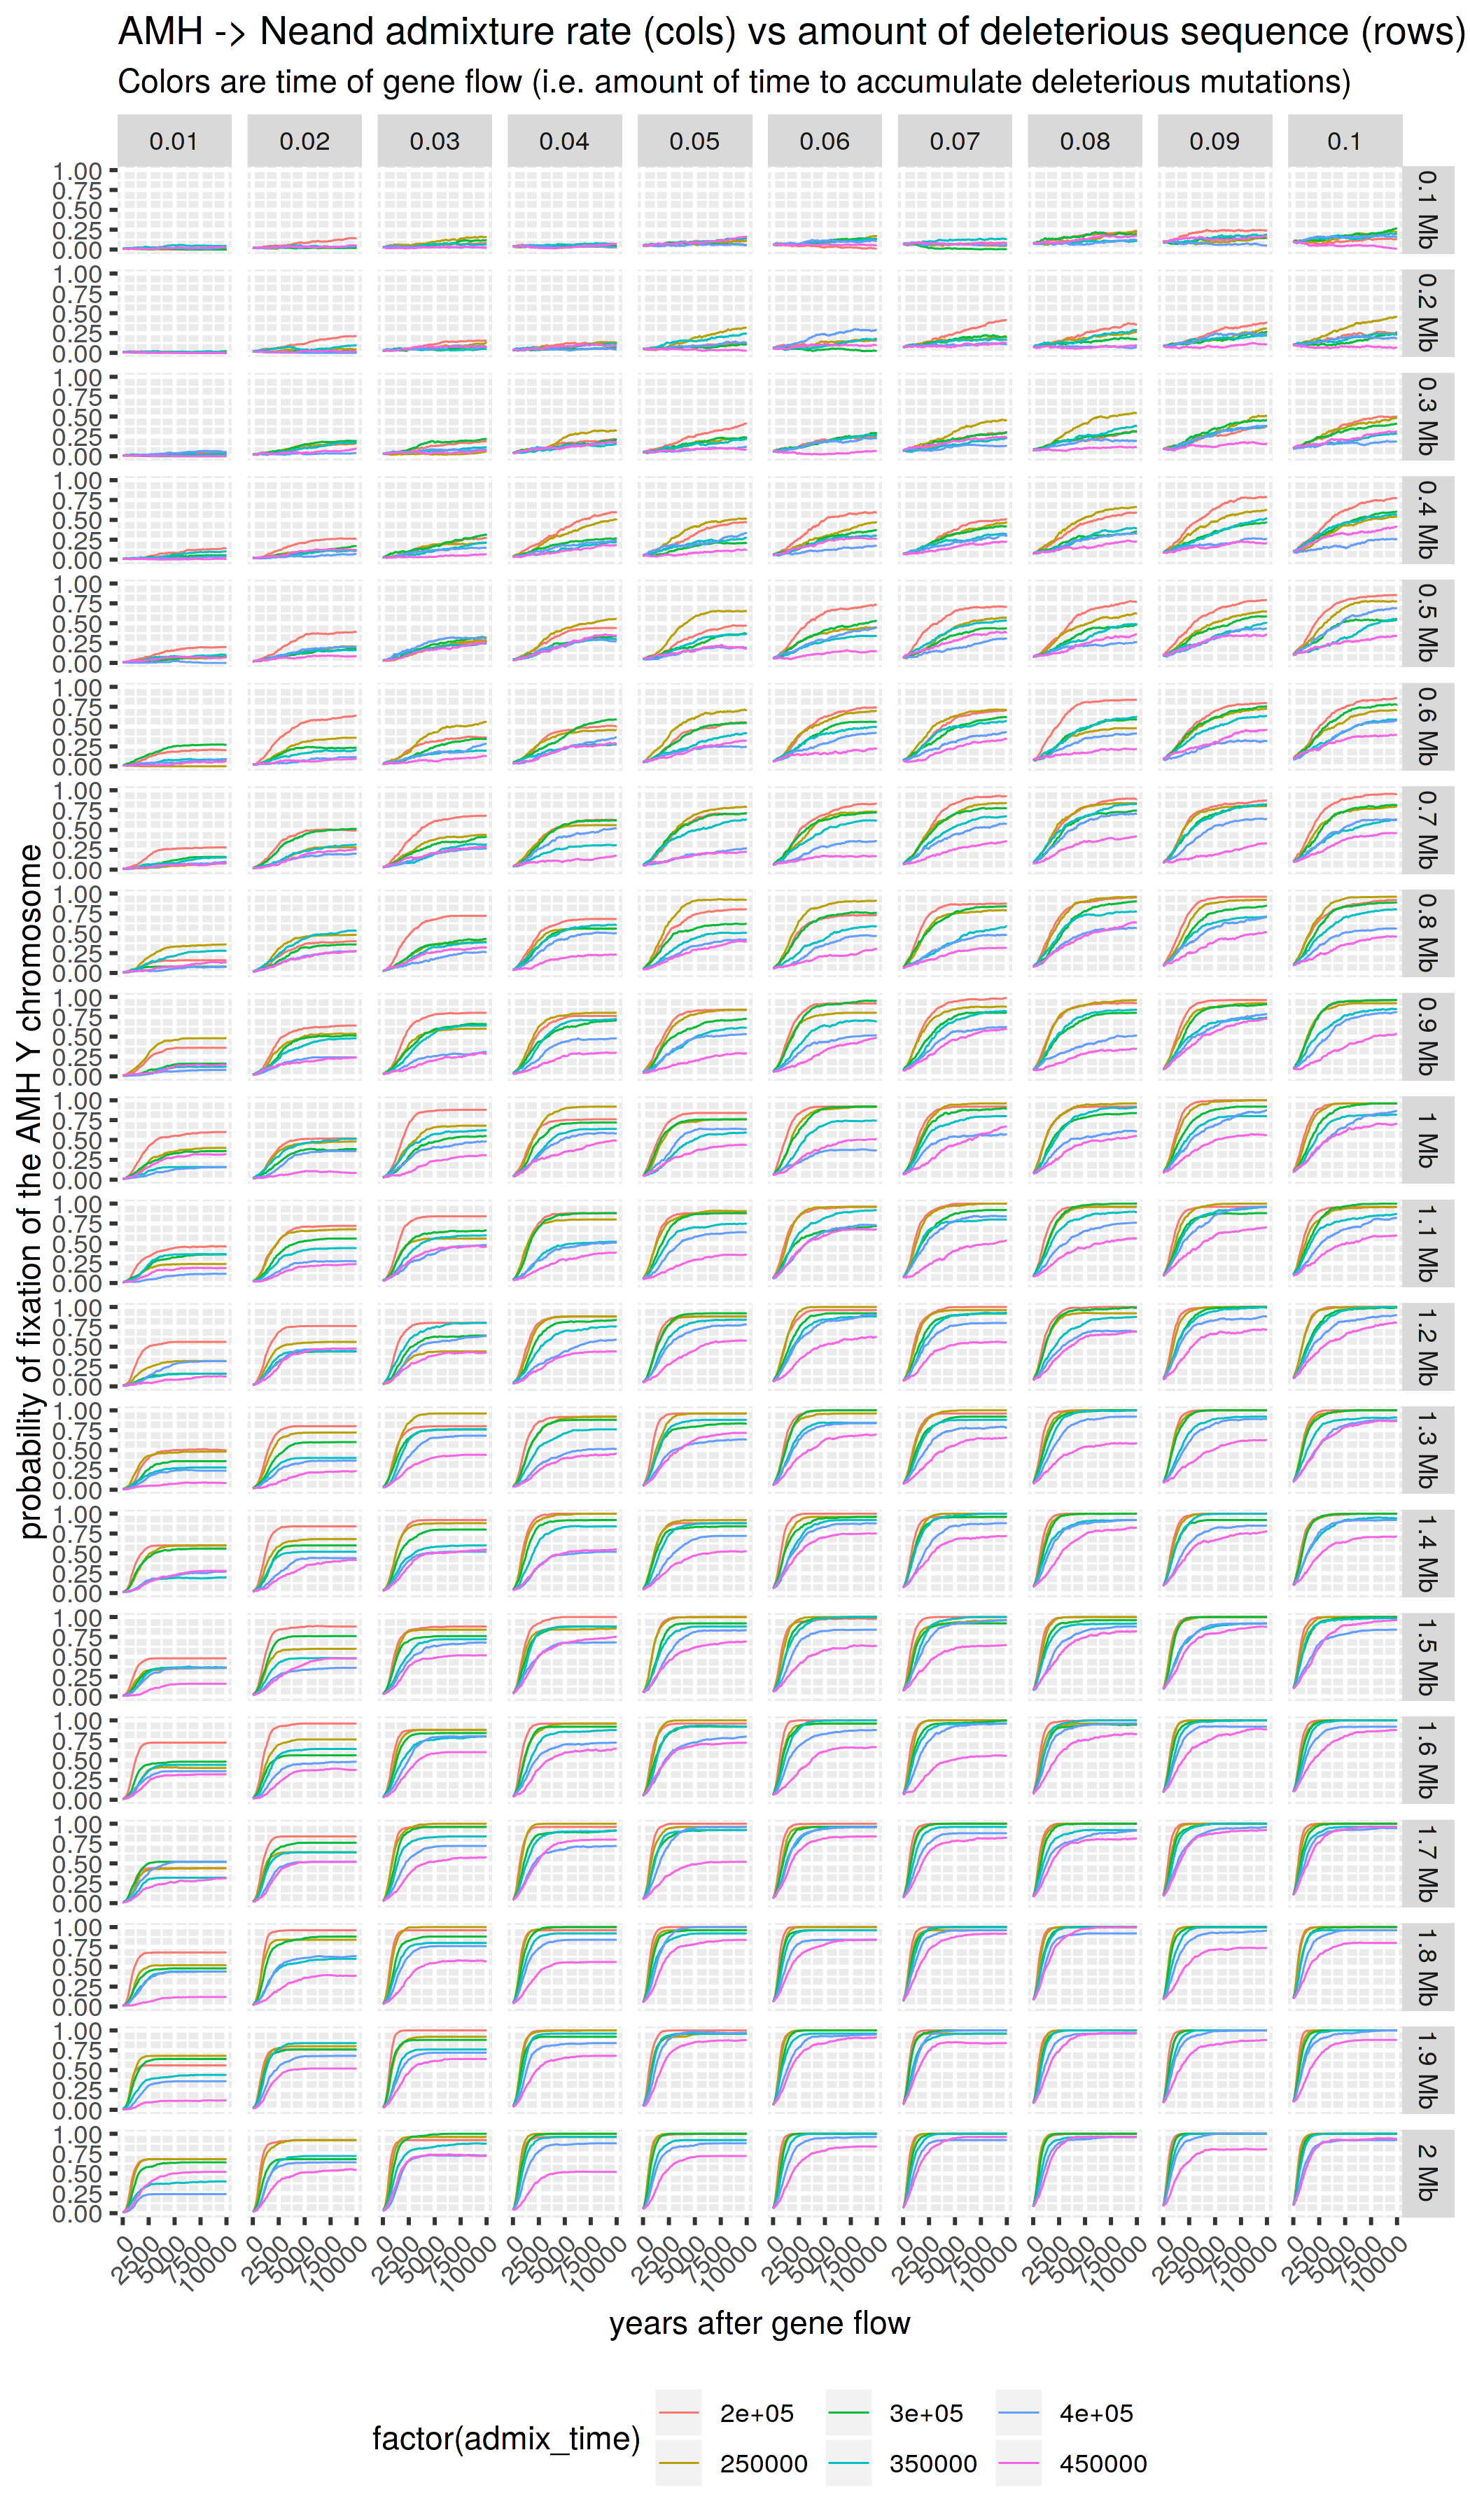

In [5]:
set_dim(7, 12)

sel_sims %>%
mutate(gene_total = paste(gene_total / 1e6, "Mb")) %>%
group_by(time, gene_total, admix_time, admix_rate) %>%
summarise_at(vars(neand), ~ mean(.x)) %>%
ggplot(aes(time, neand, color = factor(admix_time))) +
    geom_line(size = 0.25) +
    ggtitle("AMH -> Neand admixture rate (cols) vs amount of deleterious sequence (rows)",
            "Colors are time of gene flow (i.e. amount of time to accumulate deleterious mutations)") +
    xlab("years after gene flow") + ylab("probability of fixation of the AMH Y chromosome") +
    facet_grid(gene_total ~ admix_rate) +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

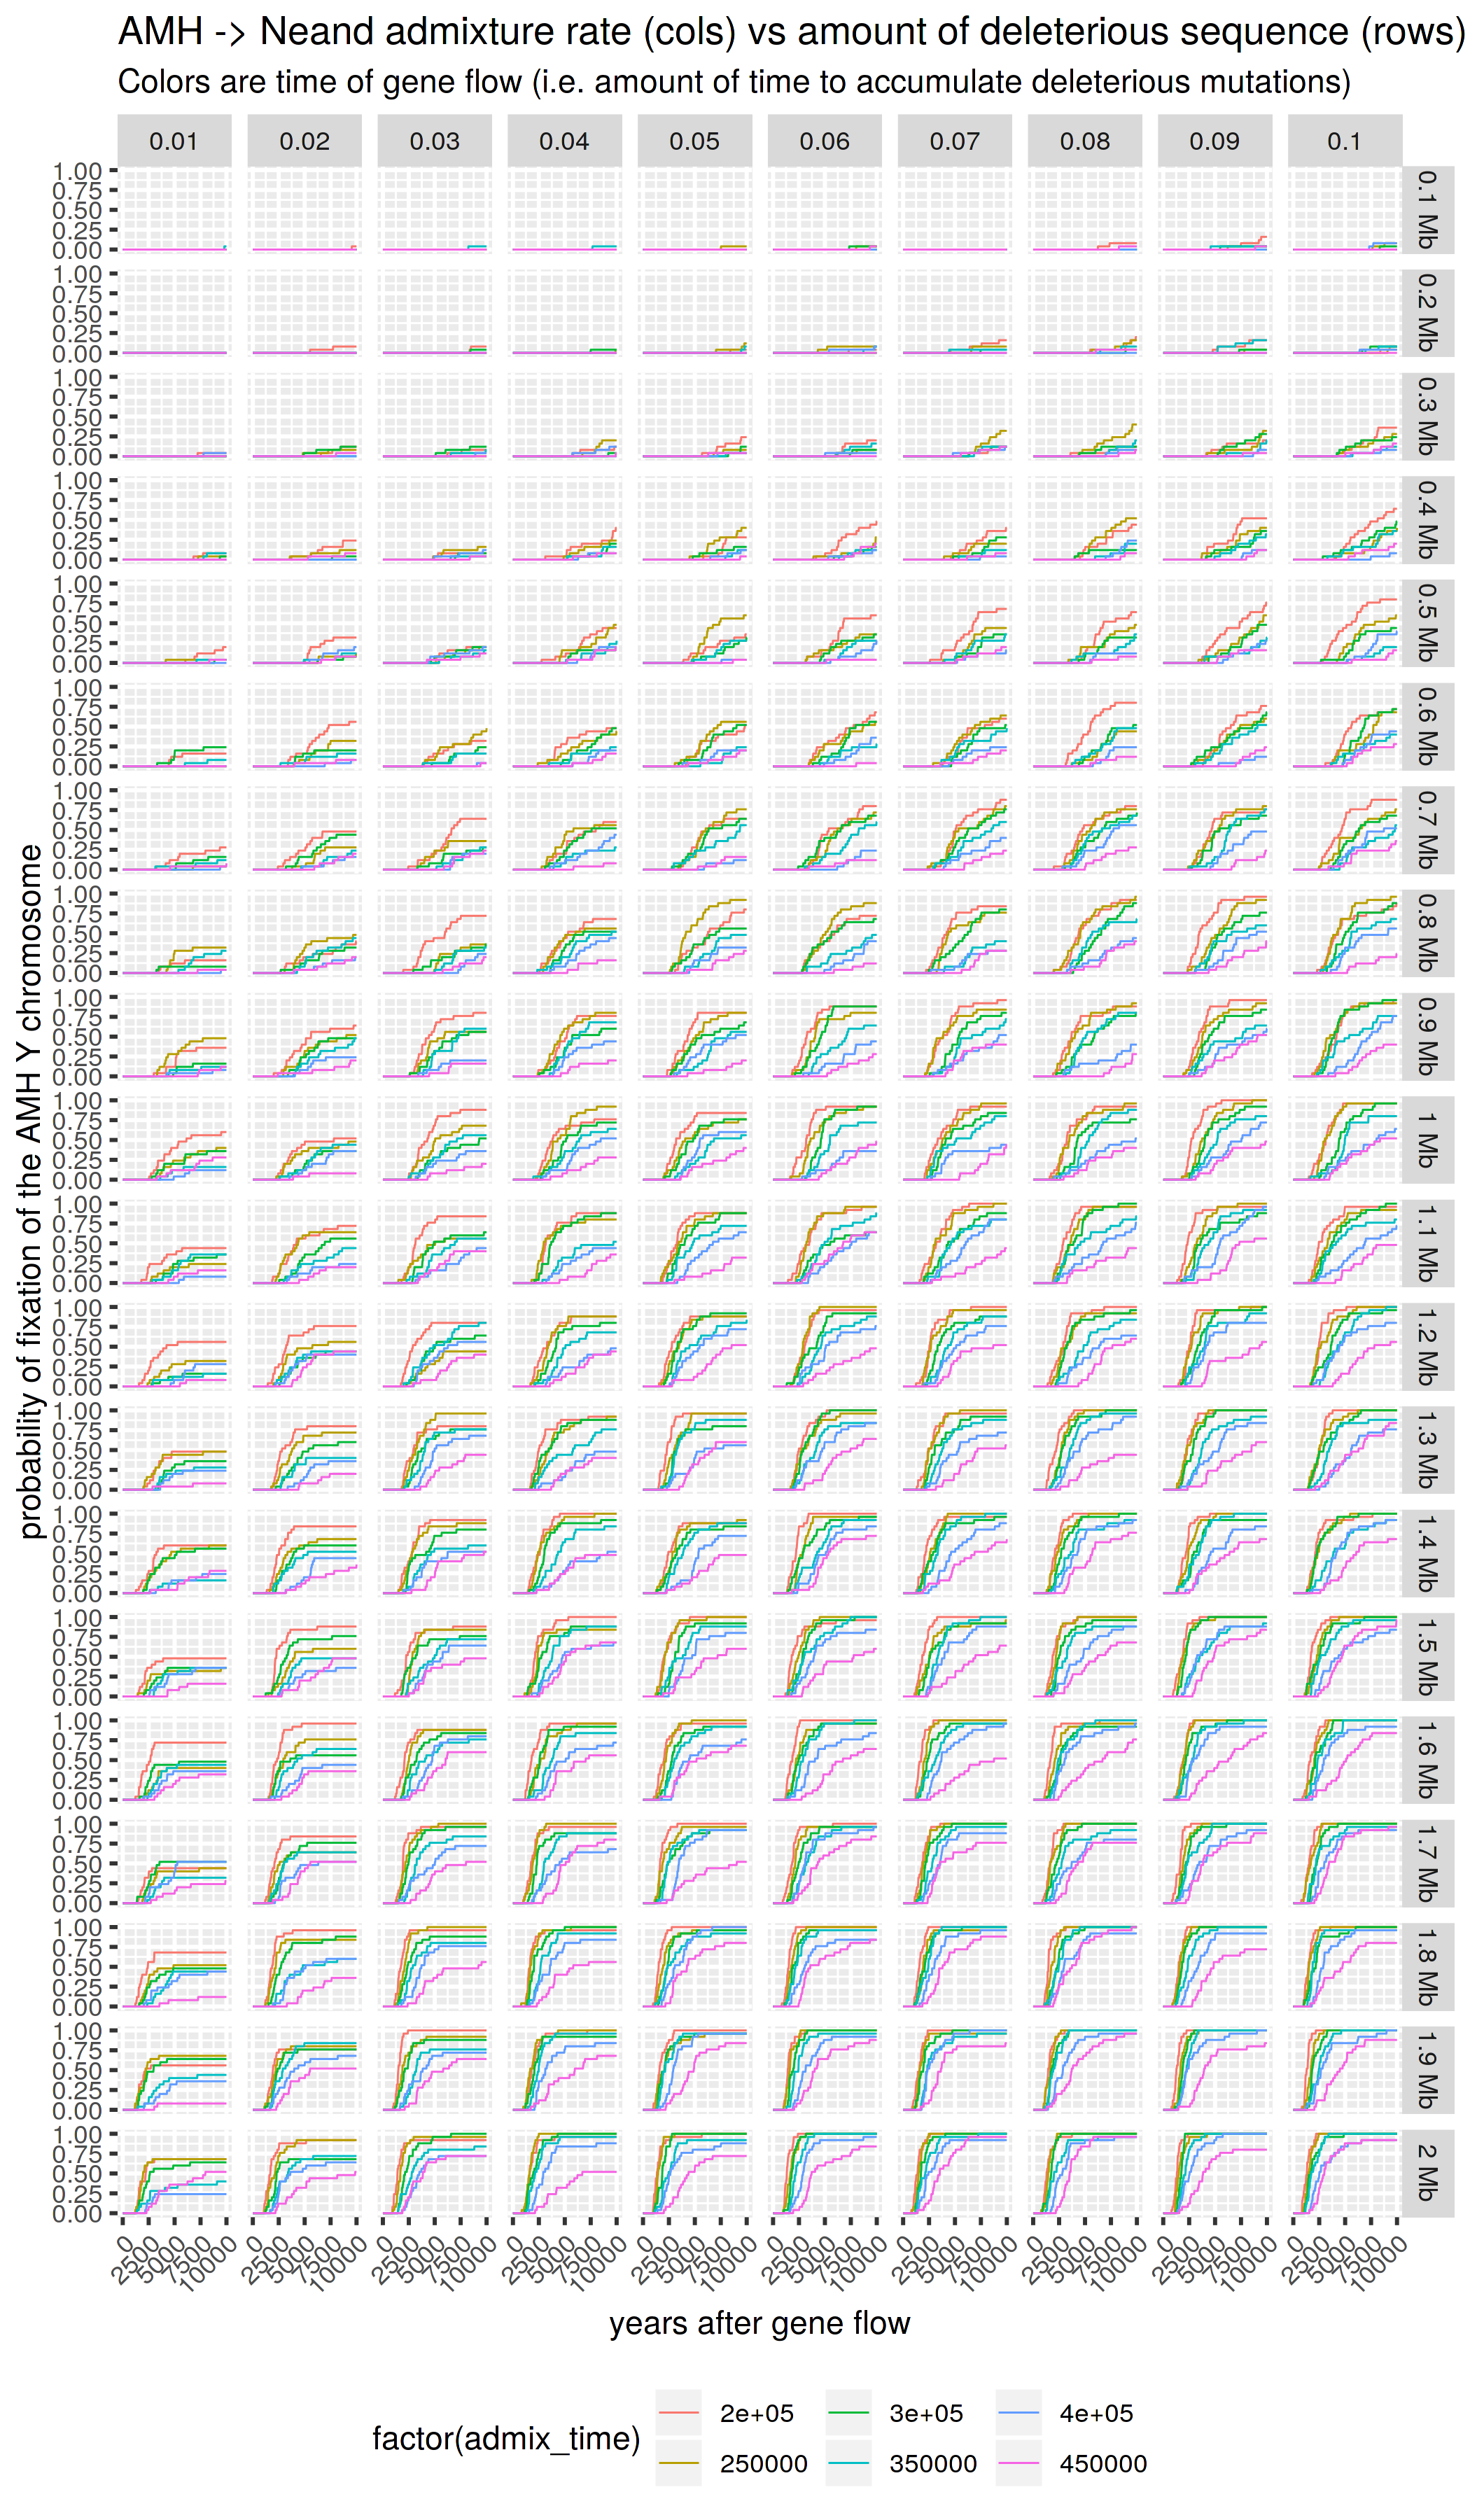

In [4]:
set_dim(7, 12)

sel_sims %>%
mutate(gene_total = paste(gene_total / 1e6, "Mb")) %>%
group_by(time, gene_total, admix_time, admix_rate) %>%
summarise_at(vars(neand), ~ mean(.x == 1)) %>%
ggplot(aes(time, neand, color = factor(admix_time))) +
    geom_line(size = 0.25) +
    ggtitle("AMH -> Neand admixture rate (cols) vs amount of deleterious sequence (rows)",
            "Colors are time of gene flow (i.e. amount of time to accumulate deleterious mutations)") +
    xlab("years after gene flow") + ylab("probability of fixation of the AMH Y chromosome") +
    facet_grid(gene_total ~ admix_rate) +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

In [52]:
x <- sel_sims %>%
group_by(admix_rate, gene_total, admix_time, gen) %>%
summarise_at(vars(neand), ~ mean(.x == 1)) %>%
filter(gen == 100)

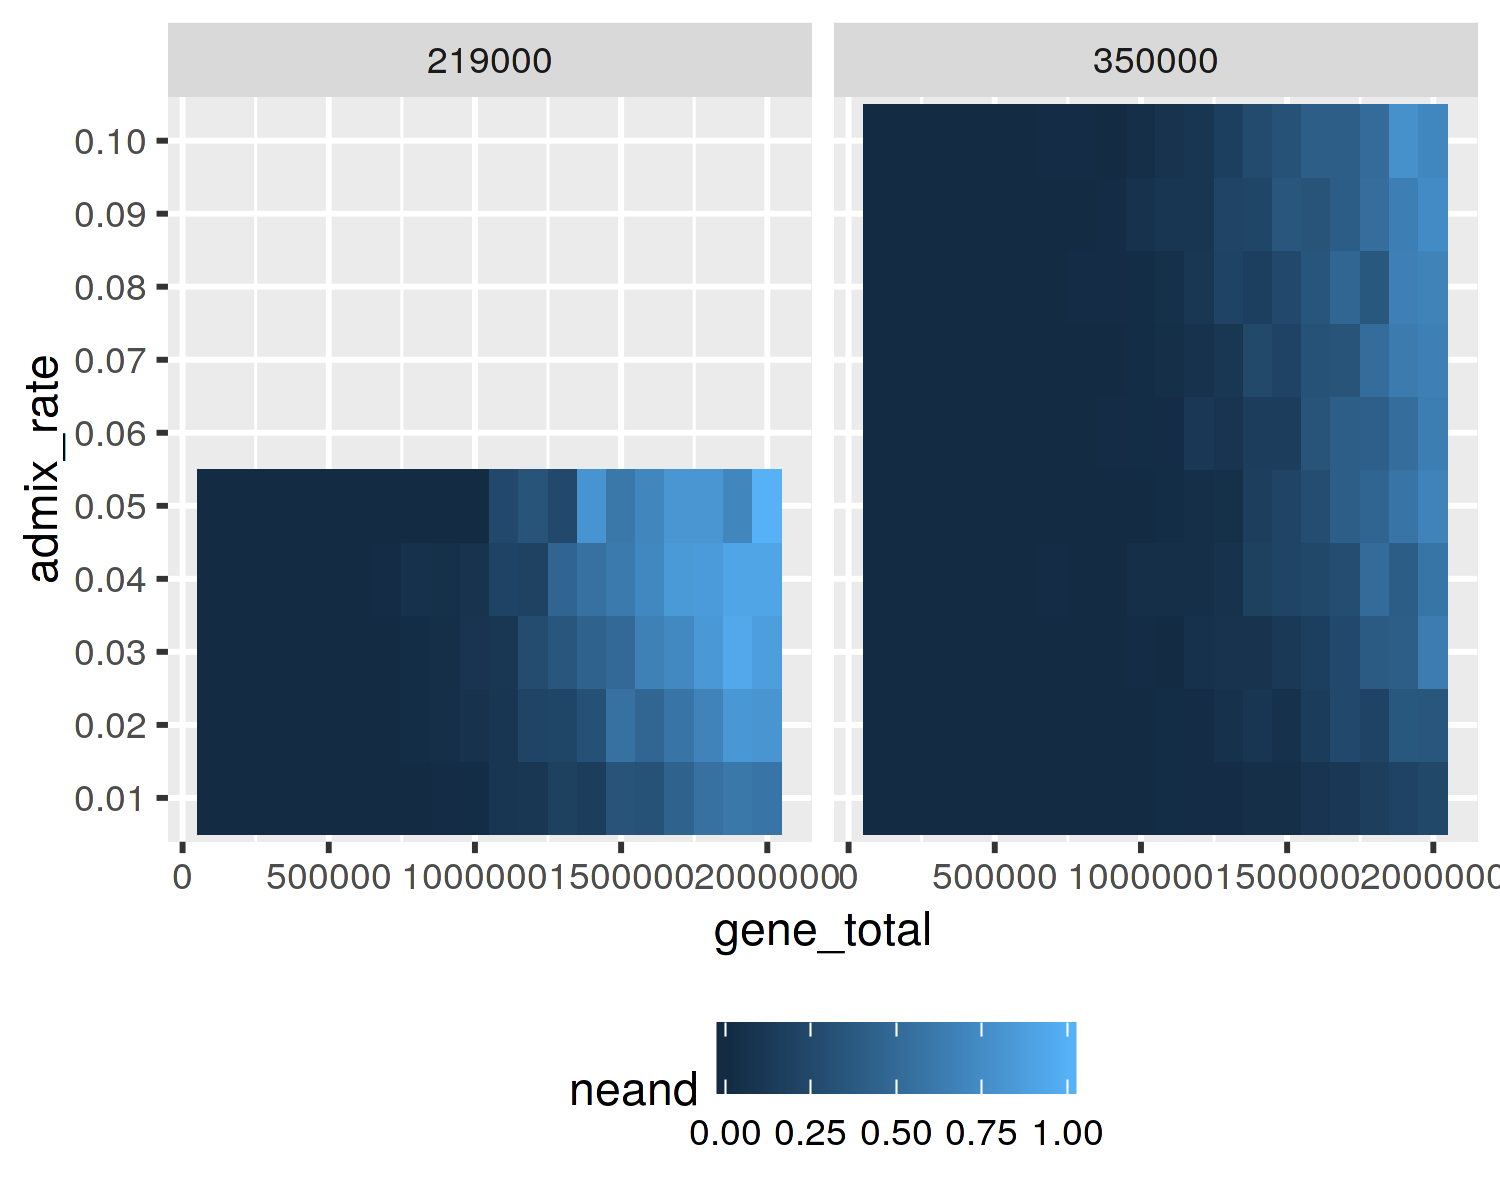

In [55]:
set_dim(5, 4)

x %>%
ggplot(aes(gene_total, admix_rate)) +
    geom_tile(aes(fill = neand)) +
    scale_fill_gradient(limits = c(0, 1)) +
    facet_wrap(~ admix_time) +
    theme(legend.position = "bottom")

In [23]:
df <-
    map_dfr(sprintf("%d", seq(100000, 2000000, 100000)), function(gene_total) {
    map_dfr(sprintf("%d", (seq(200000, 450000, 50000))), function(admix_time) {

f <- here(glue("data/sim/pops/pops_seq{gene_total}_time{admix_time}_traj.tsv"))

read_tsv(f, col_types = "id") %>%
    mutate(admix_rate = 0.05, gene_total = gene_total, admix_time = admix_time)

    })
    }) %>%
    mutate_all(as.numeric) %>%
    mutate(time = gen * 25) %>%
    select(-gen)

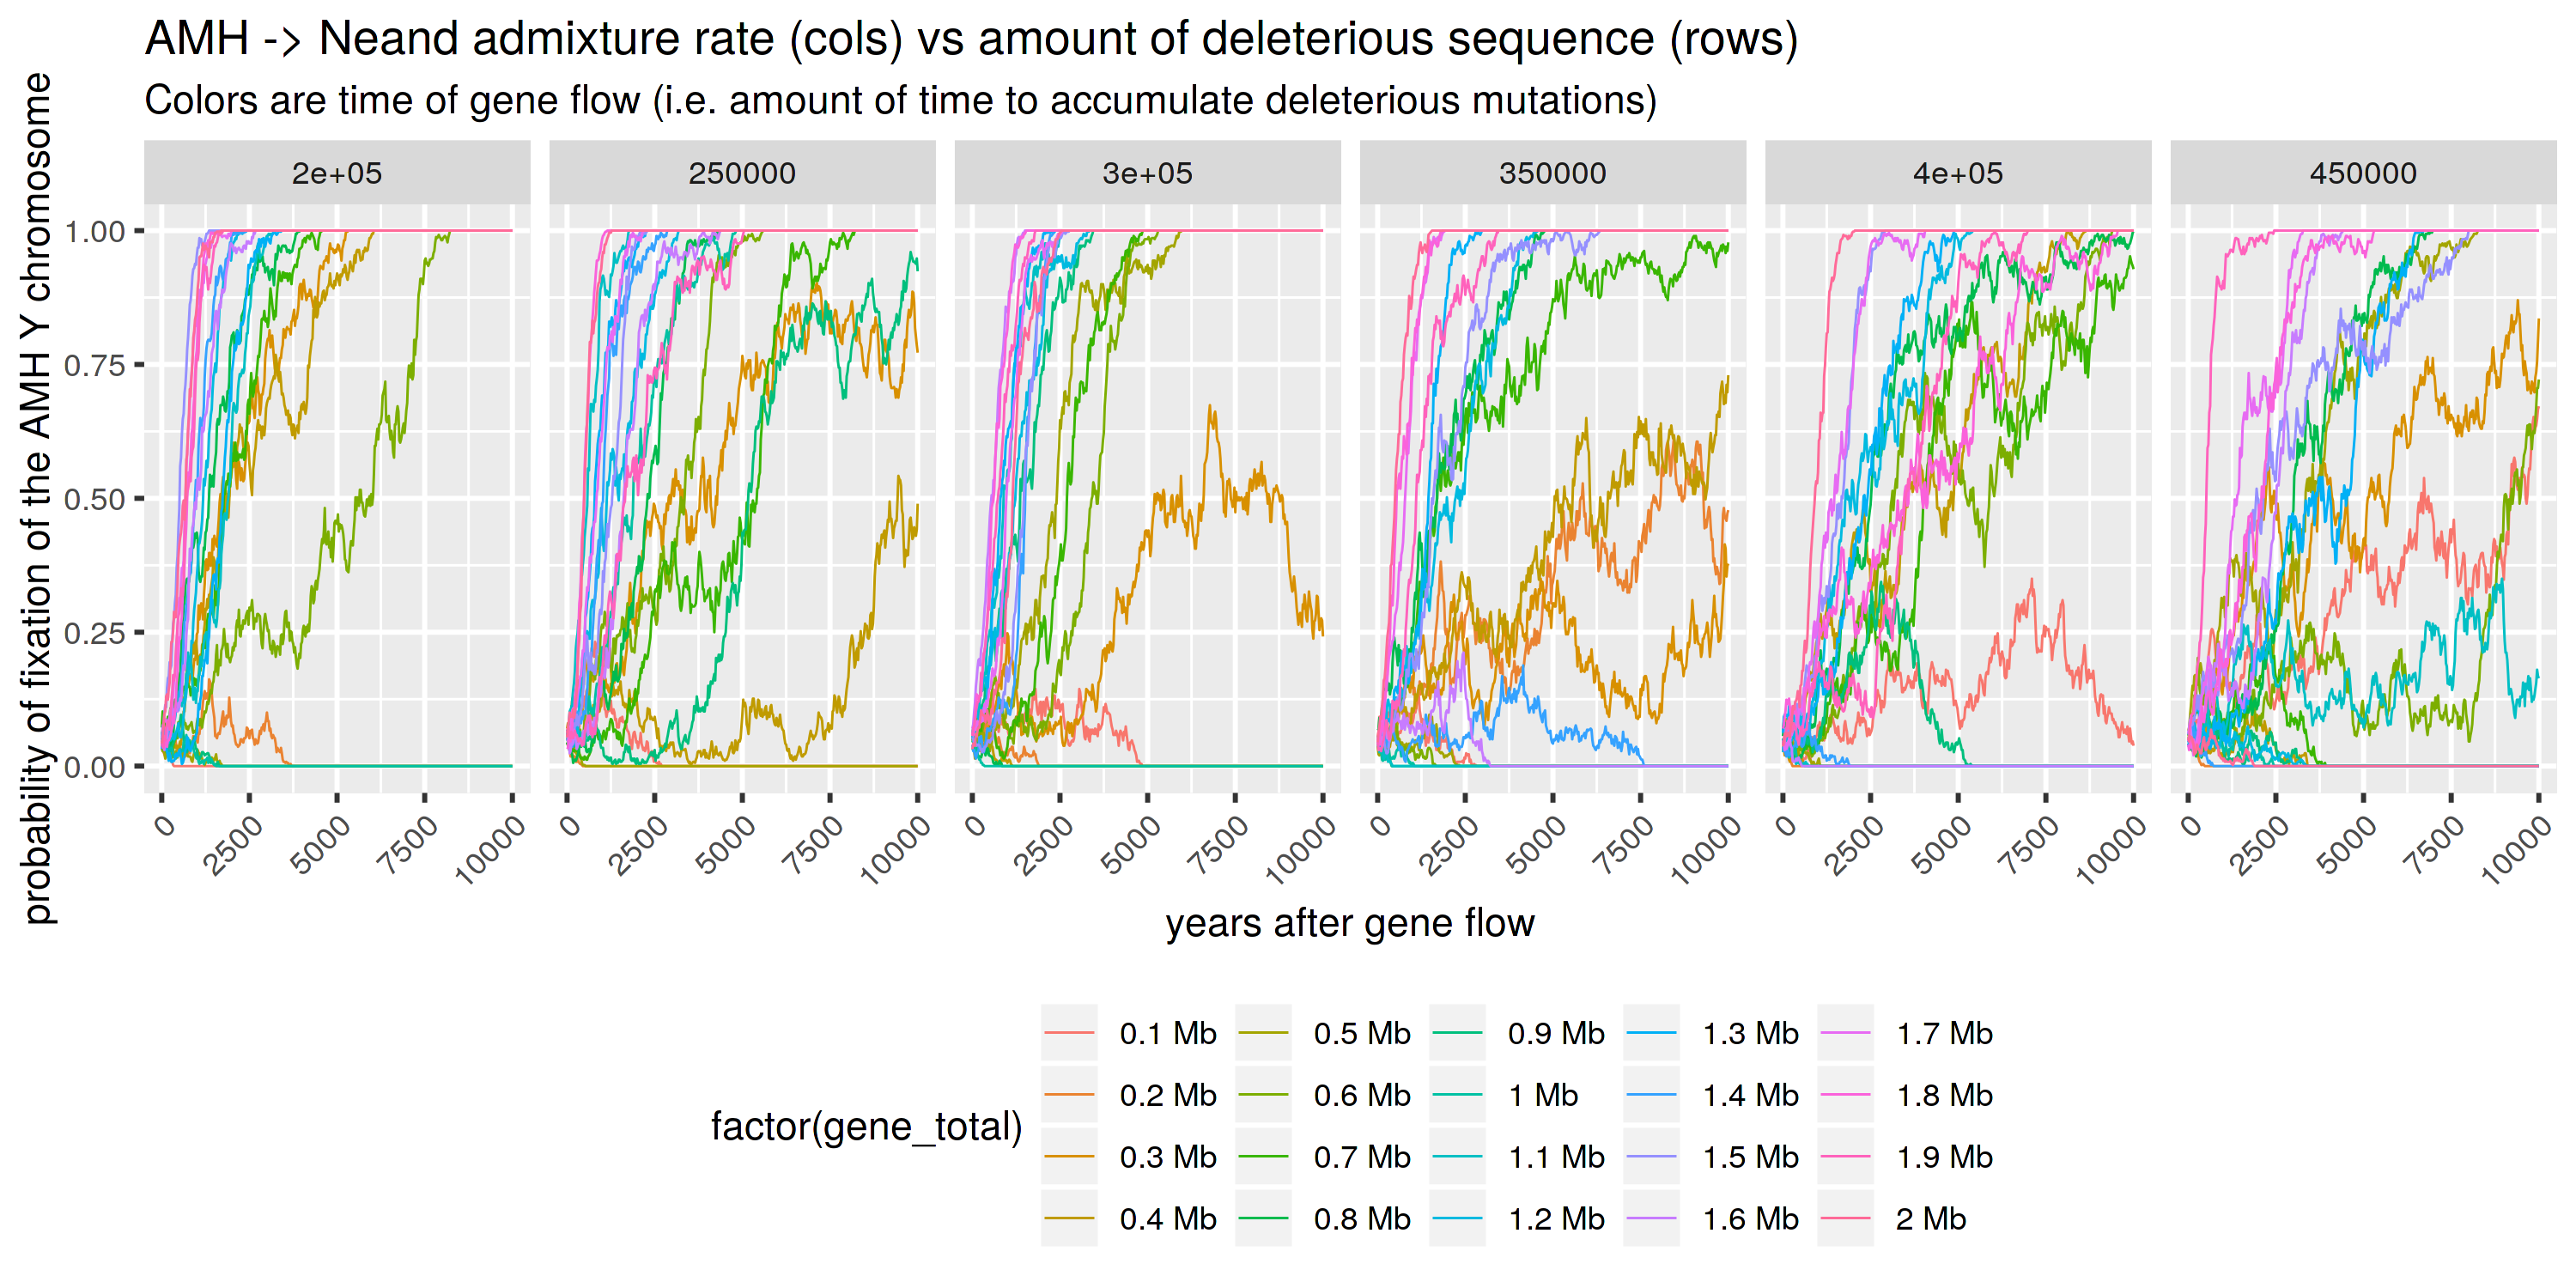

In [29]:
set_dim(10, 5)

df %>%
mutate(gene_total = paste(gene_total / 1e6, "Mb")) %>%
group_by(time, gene_total, admix_time, admix_rate) %>%
summarise_at(vars(ancestry), ~ mean(.x)) %>%
ggplot(aes(time, ancestry, color = factor(gene_total))) +
    geom_line(size = 0.25) +
    ggtitle("AMH -> Neand admixture rate (cols) vs amount of deleterious sequence (rows)",
            "Colors are time of gene flow (i.e. amount of time to accumulate deleterious mutations)") +
    xlab("years after gene flow") + ylab("probability of fixation of the AMH Y chromosome") +
    facet_grid(~ admix_time) +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

In [3]:
loads <-
    map_dfr(sprintf("%d", seq(100000, 2000000, 100000)), function(gene_total) {
    map_dfr(sprintf("%d", (seq(200000, 450000, 50000))), function(admix_time) {

f <- here(glue("data/sim/pops/pops_seq{gene_total}_time{admix_time}_pop.txt"))

loads <- read_slim(f) %>%
    calculate_load %>%
    mutate(admix_rate = 0.05, gene_total = as.integer(gene_total), admix_time = as.integer(admix_time))

    })
    })

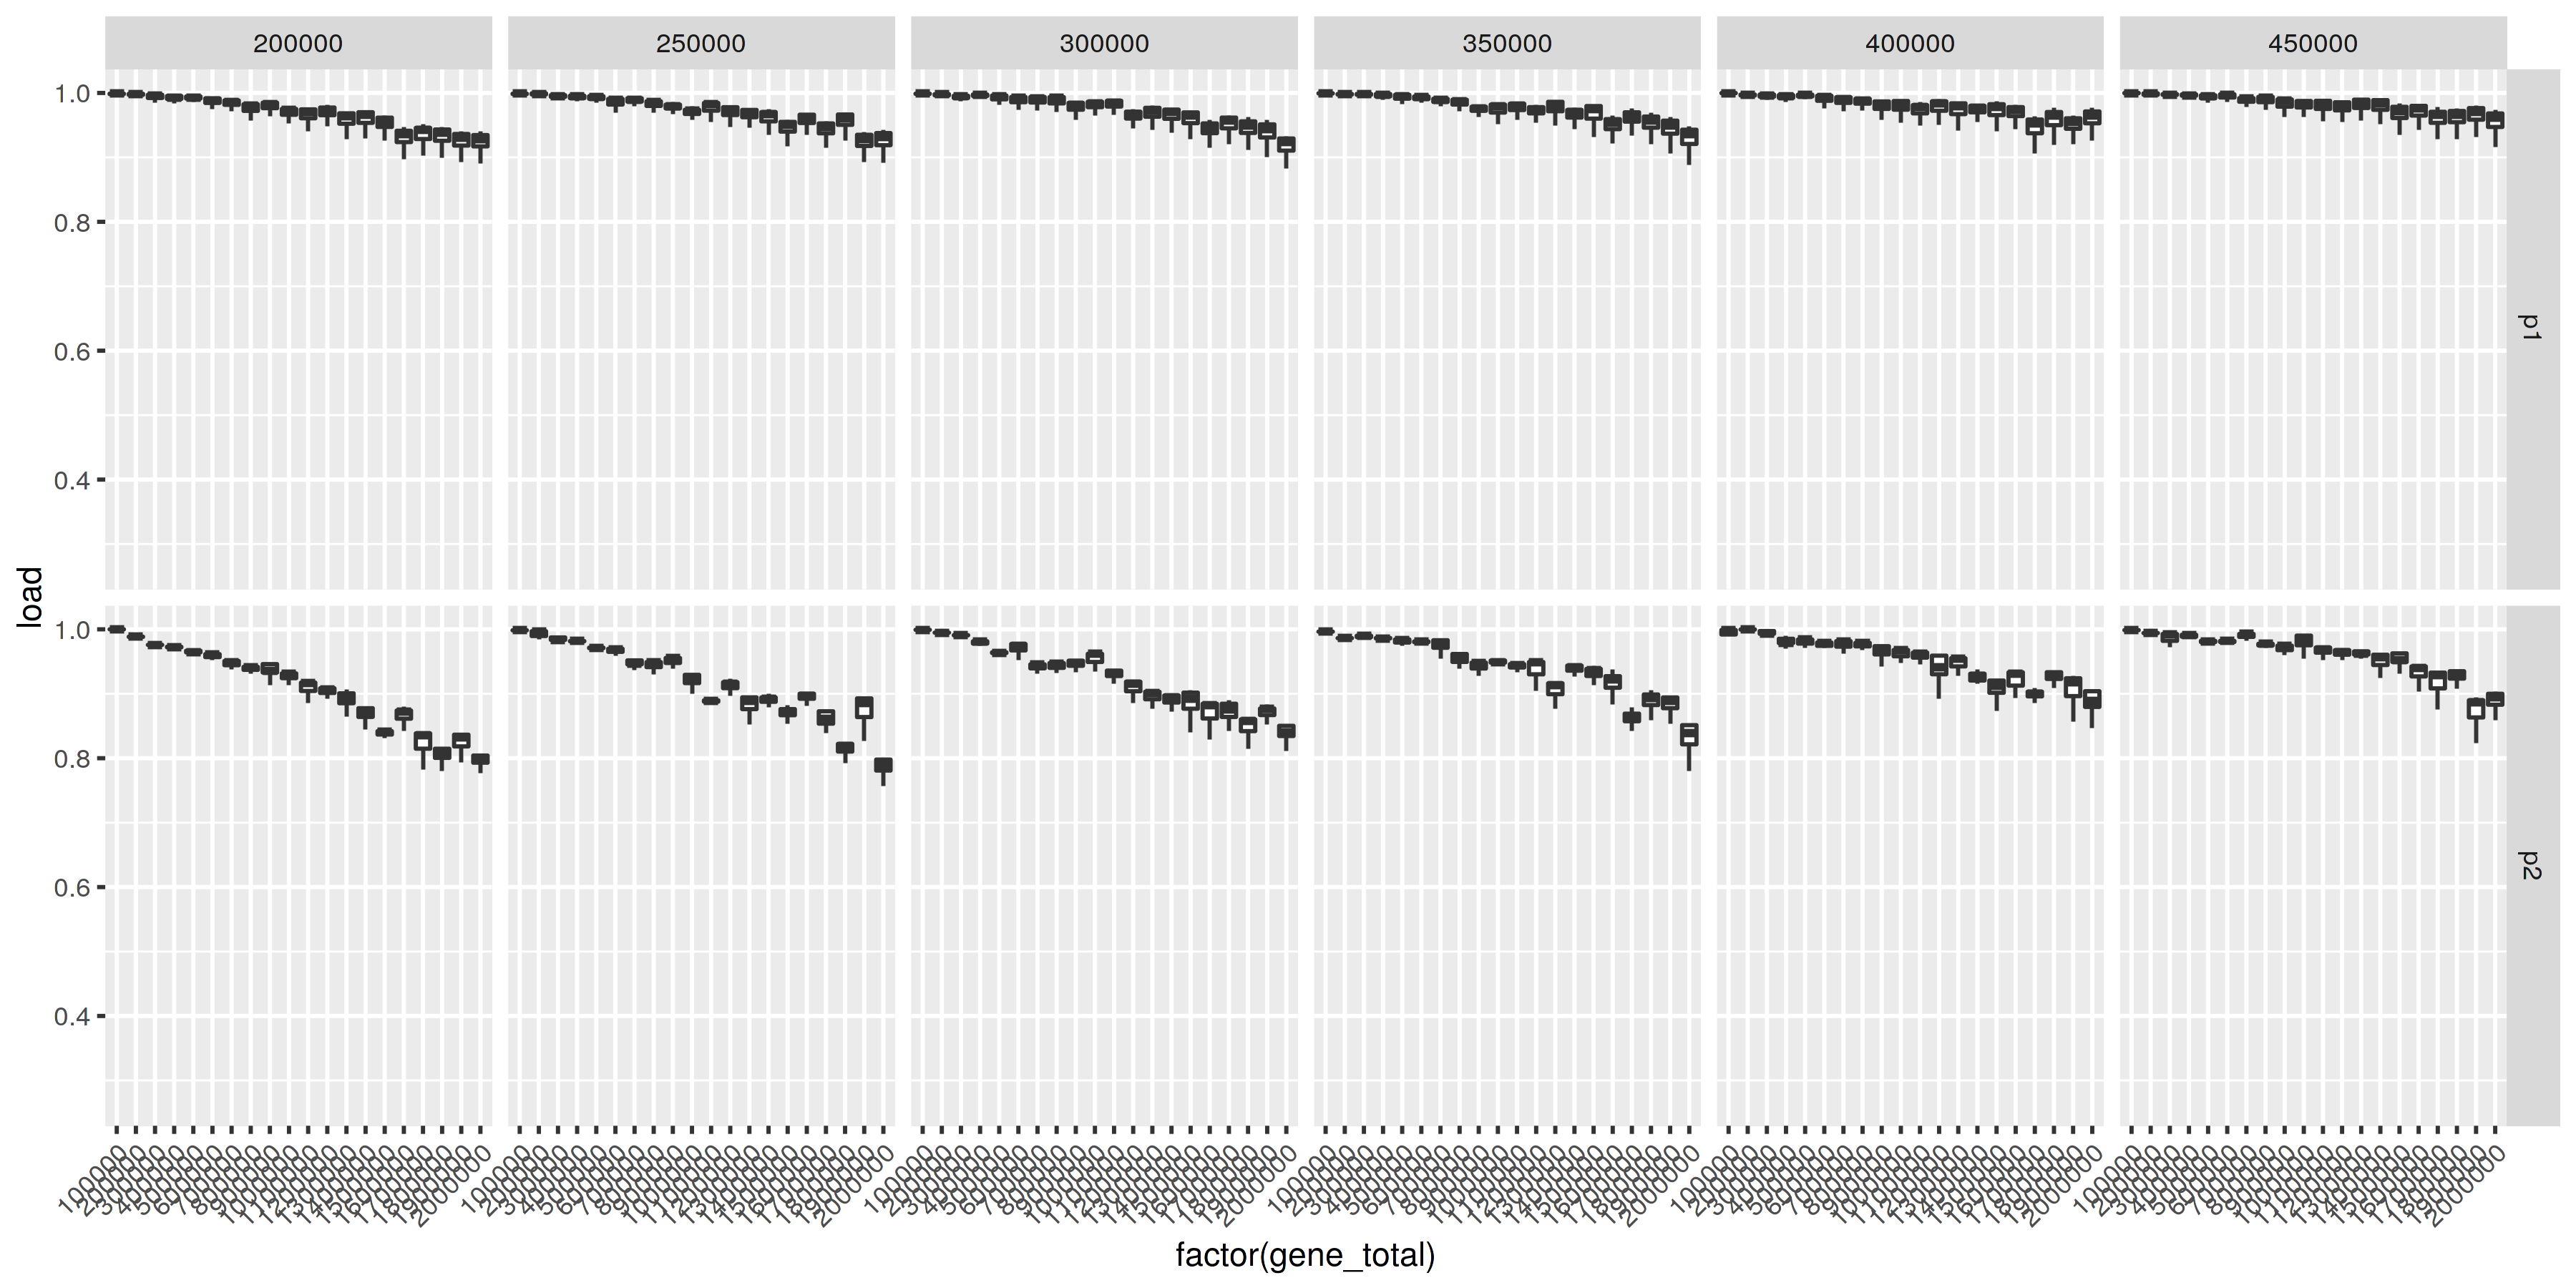

In [26]:
set_dim(12, 6)

ggplot(loads, aes(factor(gene_total), load)) +
    geom_boxplot(outlier.shape = NA) +
    facet_grid(pop ~ admix_time) +
    theme(axis.text.x = element_text(hjust = 1, angle = 45))